In [1]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
from energyflow.archs.efn import EFN
from energyflow.archs.efn import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical,remap_pids

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
import torch_geometric
import networkx as nx
plt.style.use("dark_paper")

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap="Dark2")
    return fig,ax

In [7]:
################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

###############################################################################

# load data
X, y = qg_jets.load(train + val + test)

In [8]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

print('Done train/val/test split')

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split


In [9]:
# build architecture
print('Model summary:')
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    300         phats_input[0][0]                
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
________________________________________________________________________

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]          

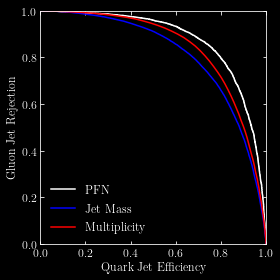

In [13]:
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

################################################################################

# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
#plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='w', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()

In [6]:
def plot_graph(h, color, epoch=None, loss=None):
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color,edge_color="w", cmap="Set2")
    return fig,ax

In [184]:
process = lambda x,y: Data(x=torch.from_numpy(x).float(),
                           y=torch.Tensor([y.argmax()]).long(),
                           #edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]).fill_diagonal_(0))[0]#complete
                           edge_index=dense_to_sparse(torch.eye(x.shape[0]))[0]#self only
                          ) 

In [210]:
train_set = [process(x[~(x==0).all(axis=1)],y) for x,y in zip(X_train,Y_train)]
val_set = [process(x[~(x==0).all(axis=1)],y) for x,y in zip(X_val,Y_val)]
test_set = [process(x[~(x==0).all(axis=1)],y) for x,y in zip(X_test,Y_test)]

In [193]:
data = train_set[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 34], x=[34, 4], y=[1])
Number of nodes: 34
Number of edges: 34
Average node degree: 1.00
Contains isolated nodes: True
Contains self-loops: True
Is undirected: True


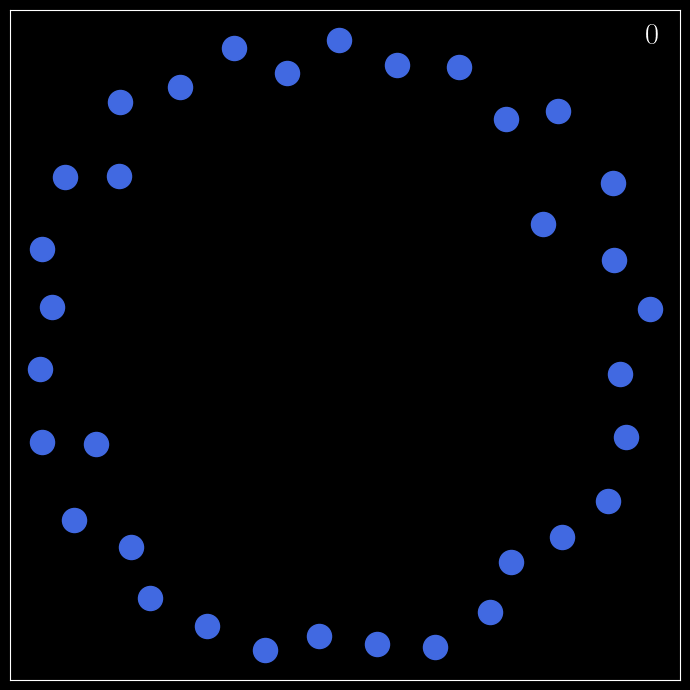

In [194]:
for i in range(1):
    data = train_set[i]
    G = to_networkx(data, to_undirected=True)
    fig,ax = plot_graph(G,color='royalblue')
    ax.text(1-0.05,0.95,
            f"{data.y.item()}",transform=ax.transAxes,
           fontsize=22)
    fig.set_dpi(100)
    plt.show()

In [259]:
from torch_geometric.nn import global_mean_pool
class GCN_global(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_global, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(4, hidden_channels) #GraphConv , here GCNConv automatically adds self loops
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = torch_geometric.nn.GCNConv(hidden_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels,hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels,hidden_channels)
        self.linear3 = torch.nn.Linear(hidden_channels,2)
    def forward(self, x, edge_index,batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x,batch)
        #x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x).relu()
        x = self.linear2(x).relu()
        x = self.linear3(x)
        return x

In [260]:
# batch = torch_geometric.data.Batch.from_data_list([train_set[0]])
# batch = torch_geometric.data.Batch.from_data_list([train_set[0]])
# out = model(batch.x,batch.edge_index,batch=batch.batch)

In [261]:
train_loader = torch_geometric.data.DataLoader(train_set,batch_size=batch_size)
val_loader = torch_geometric.data.DataLoader(val_set,batch_size=len(val_set))
test_loader = torch_geometric.data.DataLoader(test_set,batch_size=len(test_set))

In [262]:
model = GCN_global(hidden_channels=100)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    losses=[]
    for i,data in enumerate(train_loader):  # Iterate in batches over the training dataset.
        print(f"{i+1:03d}/{len(train_loader):03d}",end="\r")
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        losses.append(loss.item())
    return np.mean(losses)
def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

GCN_global(
  (conv1): GCNConv(4, 100)
  (conv2): GCNConv(100, 100)
  (conv3): GCNConv(100, 100)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=2, bias=True)
)


In [263]:
epochs = 5
for epoch in range(1, epochs+1):
    train()
    print("validating...", end="\r")
    if epoch%1==0:
        train_acc = test(train_loader)
        val_acc = test(val_loader)
        print(f'Epoch: {epoch:3d}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch:   1/5, Train Acc: 0.7753, Val Acc: 0.7912
Epoch:   2/5, Train Acc: 0.7734, Val Acc: 0.7912
Epoch:   3/5, Train Acc: 0.7793, Val Acc: 0.7912
Epoch:   4/5, Train Acc: 0.7878, Val Acc: 0.7912
Epoch:   5/5, Train Acc: 0.7848, Val Acc: 0.7912


In [257]:
with torch.no_grad():
    model.eval()
    batch = torch_geometric.data.Batch.from_data_list(test_set)
    out = model(batch.x,batch.edge_index,batch=batch.batch)


PFN AUC: 0.8743517841563484
GNN AUC: 0.8665153984512882



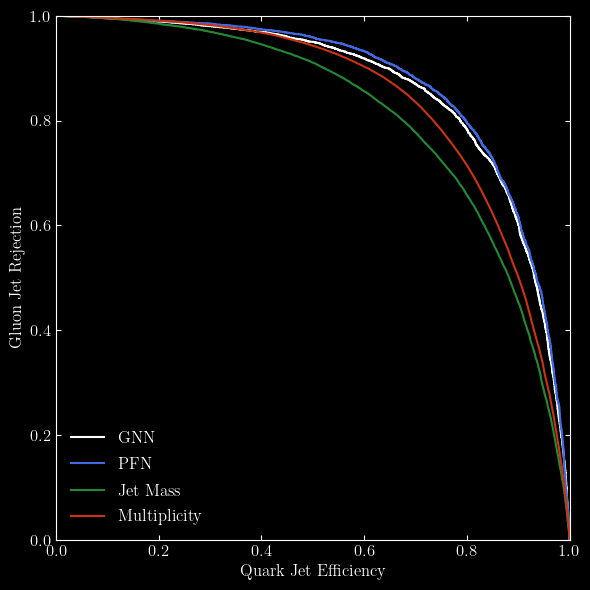

In [258]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
gnn_fp, gnn_tp, threshs = roc_curve(Y_test[:,1], preds_gnn[:,1])

# get area under the ROC curve
auc_pfn = roc_auc_score(Y_test[:,1], preds[:,1])
auc_gnn = roc_auc_score(Y_test[:,1], preds_gnn[:,1])
print()
print('PFN AUC:', auc_pfn)
print('GNN AUC:', auc_gnn)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
fig,ax = plt.subplots(1,1,dpi=100,figsize=(6,6))
#plt.rcParams['figure.figsize'] = (8,8)
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(gnn_tp, 1-gnn_fp, '-', color='w', label='GNN')
plt.plot(pfn_tp, 1-pfn_fp, '-', color='C0', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='C1', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='C2', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()

Text(0.5, 0, 'm')

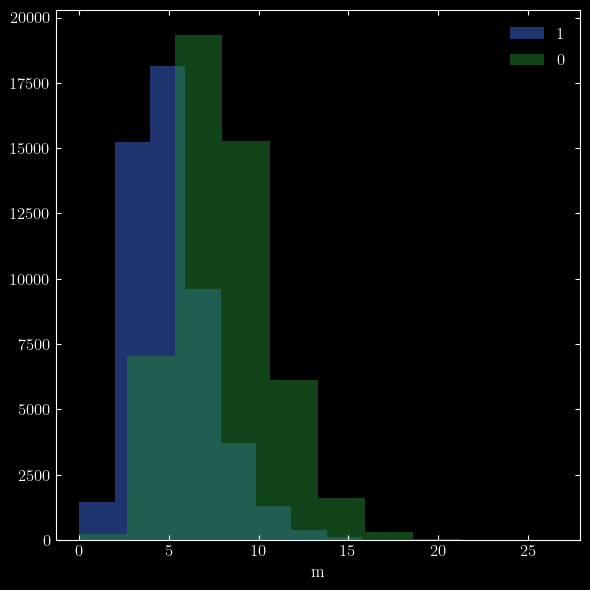

In [248]:
fig,ax = plt.subplots(1,1,dpi=100,figsize=(6,6))
plt.hist(masses[Y[:,1]==1],alpha=0.5,label="1")
plt.hist(masses[Y[:,1]==0],alpha=0.5,label="0")
plt.legend()
plt.xlabel("m")

Text(0.5, 0, 'multiplicity')

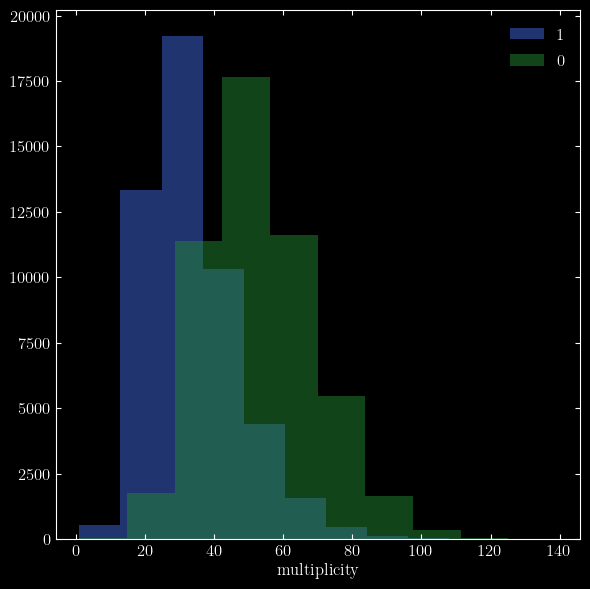

In [249]:
fig,ax = plt.subplots(1,1,dpi=100,figsize=(6,6))
plt.hist(mults[Y[:,1]==1],alpha=0.5,label="1")
plt.hist(mults[Y[:,1]==0],alpha=0.5,label="0")
plt.legend()
plt.xlabel("multiplicity")